In [ ]:
# import zipfile

# with zipfile.ZipFile("/content/drive/MyDrive/Traffic_Light_Detection/Essen.zip") as zf:
#     zf.extractall("/content/drive/MyDrive/Traffic_Light_Detection/data_drive_u/")

In [ ]:
import yaml
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
torch.cuda.empty_cache()


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, cities):
        self.imgs_path = '/content/drive/MyDrive/Traffic_Light_Detection/data_drive_u/'
        self.data = []
        self.cities = cities
        for city in self.cities:
            yml_path = self.imgs_path + 'DTLD_Labels/' + city + '_all.yml'
            with open(yml_path, 'r') as stream:
                yaml_file = yaml.safe_load(stream)
            for img_info in yaml_file:
                good_lights = 0
                for obj in img_info['objects']:
                    st = str(obj['class_id'])
                    if st[0] == '1' and st[3] == '3' and int(st[5]) <= 4 and st[1] == '1' and obj['width'] > 0 and obj['height'] > 0:
                        good_lights += 1
                if good_lights > 0:
                    img_path = self.imgs_path + '/'.join(img_info['path'].split('/')[-4:])
                    self.data.append([img_path, img_info['objects']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, objects = self.data[idx]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (2048, 1024))
        img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2BGR)
        # Images are saved in 12 bit raw -> shift 4 bits
        img = np.right_shift(img, 4)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img /= 255.0

        target = {'boxes': [], 'labels': [], 'iscrowd': []}
        for obj in objects:
            st = str(obj['class_id'])
            if st[0] == '1' and st[3] == '3' and int(st[5]) <= 4 and obj['width'] > 0 and obj['height'] > 0:
                target['boxes'].append([obj['x'], obj['y'], obj['x'] + obj['width'], obj['y'] + obj['height']])
                if int(st[4]) <= 2:
                    target['labels'].append(int(st[4]) + 1)
                else:
                    target['labels'].append(int(st[4]))
                if st[1] == '1':
                    target['iscrowd'].append(0)
                else:
                    target['iscrowd'].append(1)
            
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
        target['iscrowd'] = torch.as_tensor(target['iscrowd'], dtype=torch.int64)

        img_tensor = torch.as_tensor(img.copy(), dtype=torch.float32)
        return img_tensor, target

In [ ]:
train_dataset = CustomDataset(['Bochum', 'Fulda'])
test_dataset = CustomDataset(['Bremen'])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
images, targets = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


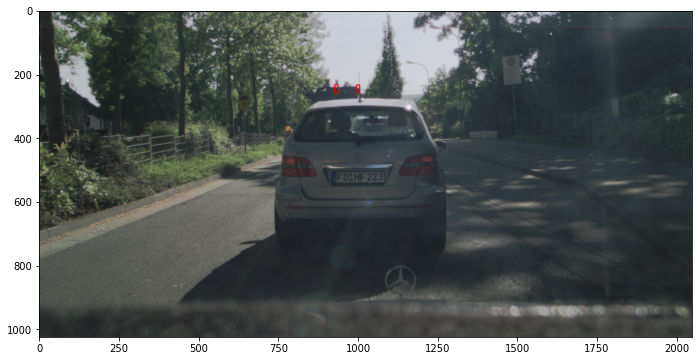

In [ ]:
sample = images[0].numpy().astype(np.float32)
boxes = targets[0]['boxes'].numpy().astype(np.float32)
for box in boxes:
    sample = cv2.rectangle(sample, (box[0], box[1]),
                (box[2], box[3]),
                (220, 0, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sample = cv2.UMat(sample).get()
ax.imshow(sample)

In [ ]:
num_classes = 5

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.nms_thresh = 0.3

model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
loss_epoch = []
for epoch in range(10):
    model.train()

    loss_iteration = []
    i = 0
    for images, targets in train_loader:
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images.permute(0, 3, 1, 2).float(), targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_iteration.append(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print("Epoch:{:4d}, Iteration:{:4d}, Loss:{:4.4f}"
                  .format(epoch, i, loss_iteration[-1]))
        i += 1
    loss_epoch.append(np.array(loss_iteration).mean())
    
    PATH = '/content/drive/MyDrive/Traffic_Light_Detection/models/fastercnn_nms_epoch' + str(epoch) + '.pt'
    torch.save(model.state_dict(), PATH)
    lr_scheduler.step()